In [6]:
!pip install rasterio

In [7]:
!pip install mpl-interactions

In [8]:
!pip install ipympl

In [9]:
import matplotlib.pyplot as plt
import tarfile
import json
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
import seaborn as sns
import csv
from google.colab import output
output.enable_custom_widget_manager()

from mpl_interactions import ioff, panhandler, zoom_factory
%matplotlib widget

## Ground survey analysis

In [ ]:
path_22 = "/content/drive/MyDrive/Research_project/ground_surveys/lymeregis-26-9-22.csv"

df22 = pd.read_csv(path_22)

# Convert longitude and latitude to a geometric Point object
df22['geometry'] = df22.apply(lambda row: Point(row.Easting, row.Northing), axis=1)

# Convert DataFrame to GeoDataFrame
gdf22 = gpd.GeoDataFrame(df22, geometry='geometry', crs="EPSG:27700")

In [ ]:
gdf22.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [ ]:
## Convert the CRS to WGS 84
gdf22 = gdf22.to_crs("EPSG:4326")

In [ ]:
# Check if it took effect
gdf22.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

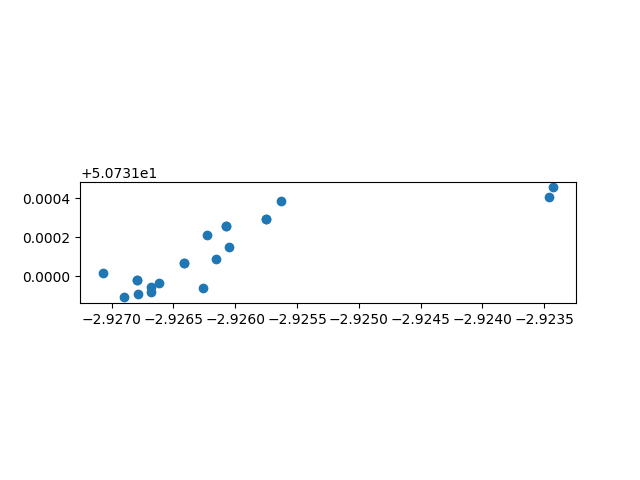

In [ ]:
# Plot the data
gdf22.plot()

In [ ]:
path_21 = "/content/drive/MyDrive/Research_project/ground_surveys/LRblocklocalitiesOct21.csv"
df21 = pd.read_csv(path_21)

# Convert longitude and latitude to a geometric Point object
df21['geometry'] = df21.apply(lambda row: Point(row.Easting, row.Northing), axis=1)

# Convert DataFrame to GeoDataFrame
gdf21 = gpd.GeoDataFrame(df21, geometry='geometry', crs="EPSG:27700")

print(gdf21.crs)

EPSG:27700


In [ ]:
## Convert the points to universal crs
gdf21 = gdf21.to_crs("EPSG:4326")

gdf21.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

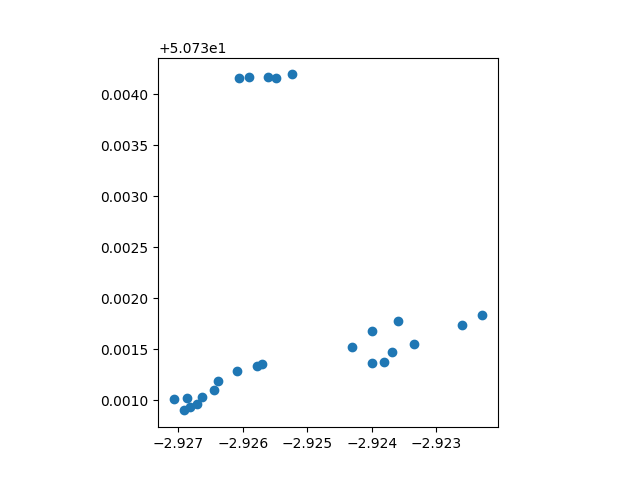

In [ ]:
gdf21.plot()

In [ ]:
gdf21.head()

,Easting,Northing,Elevation,Comment,GPS Date,GNSS Height,Vert Prec,Horz Prec,Std Dev,Point_ID,geometry
0,334983.606,92863.659,21.690,206,07-Oct-21,21.689886,4.881054,3.785629,0.721652,17,POINT (-2.92260 50.73173)
1,335006.021,92874.901,20.876,207,07-Oct-21,20.875938,4.900374,3.781773,0.733204,18,POINT (-2.92229 50.73184)
2,334930.595,92843.851,30.887,208,07-Oct-21,30.887134,4.723854,3.703480,1.411236,19,POINT (-2.92335 50.73155)
3,334913.326,92868.888,42.533,209,07-Oct-21,42.532542,4.792416,3.670735,1.683039,20,POINT (-2.92360 50.73177)
4,334906.852,92835.377,32.057,210,07-Oct-21,32.056516,4.741265,3.629918,1.496467,21,POINT (-2.92369 50.73147)


In [ ]:
x1, y1, x2, y2, point_id = [], [], [], [], []

distance_lst = []

for index, row in gdf21.iterrows():

    temp = gdf22.loc[gdf22['Point_ID'] == row["Point_ID"]]
    if not temp.empty:
      origin = (row.geometry.x, row.geometry.y)
      dist = (temp.geometry.x.values[0], temp.geometry.y.values[0])
      distance_lst.append(geodesic(origin, dist).meters)

      x1.append(row.geometry.x)
      y1.append(row.geometry.y)
      x2.append(temp.geometry.x.values[0])
      y2.append(temp.geometry.y.values[0])
      point_id.append(row["Point_ID"])

x1 = np.array(x1)
x2 = np.array(x2)

y1 = np.array(y1)
y2 = np.array(y2)

diff_x = x2 - x1
diff_y = y2 - y1

info_df = pd.DataFrame(list(zip(point_id,x1,y1, x2, y2, distance_lst, diff_x, diff_y)), columns = ["point_id", "orig_lat", "orig_long", "end_lat", "end_long", "distance_meters", "diff_lat", "diff_long"])
info_df.sort_values(by="point_id", inplace=True)
info_df = info_df.reset_index(drop=True)

In [ ]:
info_df.to_csv("/content/drive/MyDrive/Research_project/ground_survey_combined_analysis.csv")

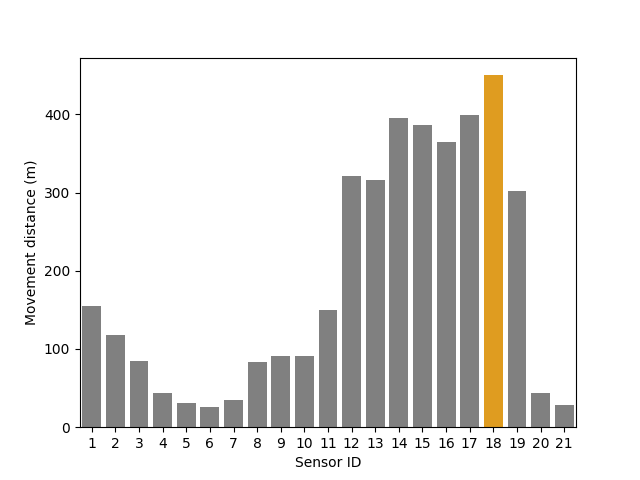

In [ ]:
cols = ['grey' if (x < max(info_df.distance_meters)) else 'orange' for x in info_df.distance_meters]

plt.figure()
ax = sns.barplot(data=info_df, x="point_id", y="distance_meters", palette=cols)
ax.set(xlabel='Sensor ID', ylabel='Movement distance (m)')
plt.savefig("/content/drive/MyDrive/Research_project/barplot_distance_comparison.png")
plt.show()

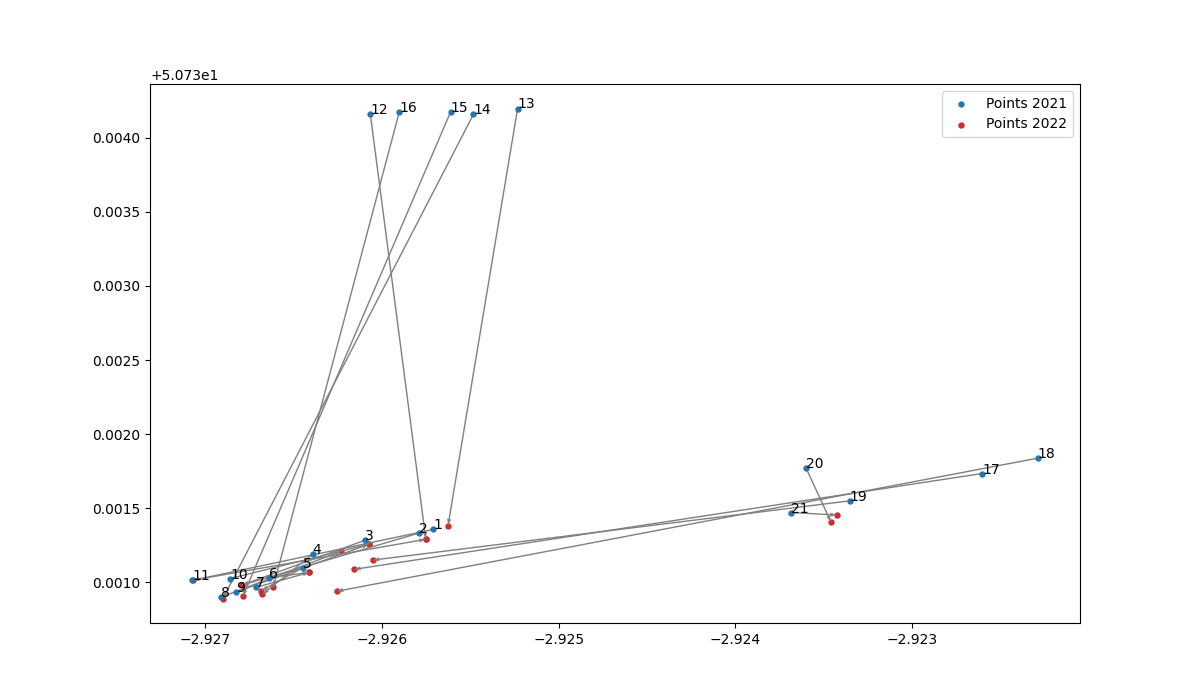

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

AB = ax.scatter(x1, y1, c = 'tab:blue', marker = '.', s = 50, zorder=2,label="Points 2021")
CD = ax.scatter(x2, y2, c = 'tab:red', marker = '.', s = 50, label="Points 2022")

for i, txt in enumerate(point_id):
    ax.annotate(txt, (x1[i], y1[i]), fontsize=10)

ax.quiver(x1, y1, diff_x, diff_y, angles='xy', scale_units='xy', scale=1, width=0.0015, color="grey")

plt.legend()
plt.show()

In [ ]:
img_path = "/content/drive/MyDrive/Research_project/full_lyme_regis_S2_v4/tif_images_masked/default_response_010870f164f9e178ea95a67334fecc8e.tif"

src = rasterio.open(img_path)

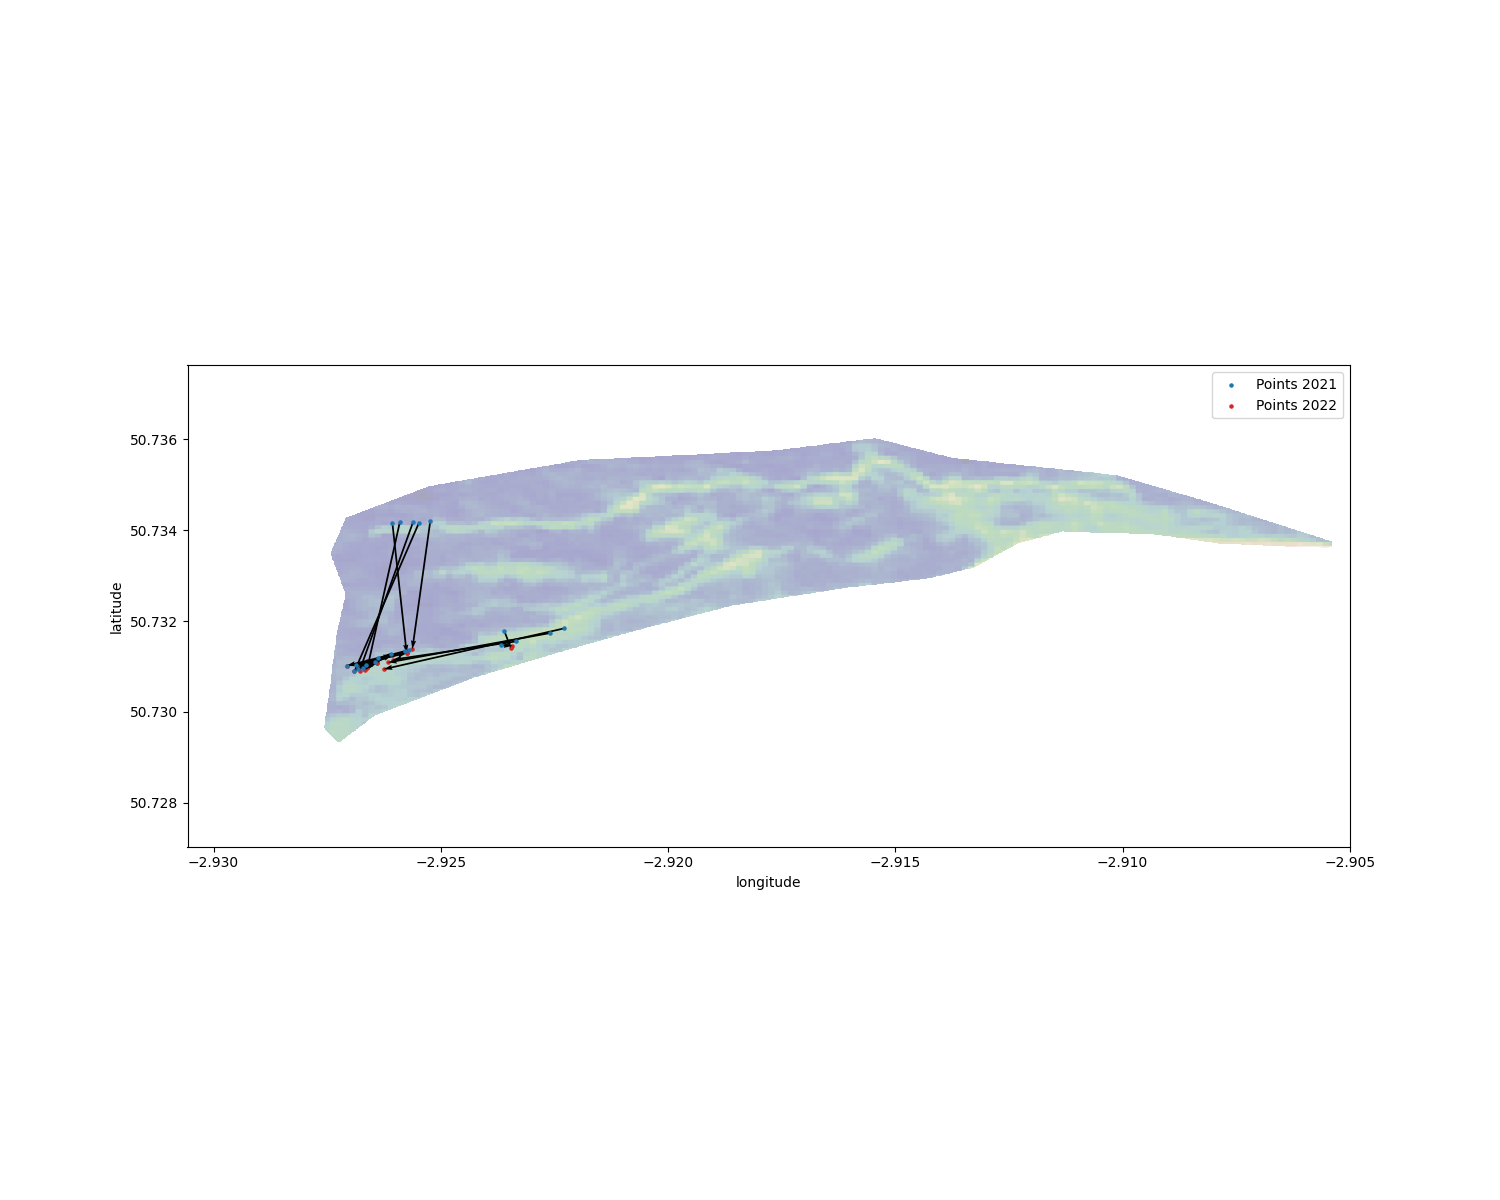

In [ ]:
# Create a interactive plot to see the point better
with plt.ioff():
    fig, ax = plt.subplots(figsize=(15,12))

# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap="gist_earth", alpha=0.35)
#fig, ax = plt.subplots()
AB = ax.scatter(x1, y1, c = 'tab:blue', marker = '.', s = 20, zorder = 2, label="Points 2021")
CD = ax.scatter(x2, y2, c = 'tab:red', marker = '.', s = 20, label="Points 2022")

ax.quiver(x1, y1, (x2-x1), (y2-y1), angles='xy', scale_units='xy', scale=1, width=0.0015)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend()

plt.savefig("/content/drive/MyDrive/Research_project/ground_surveys/ground_points.png")

# Create the map interactive to zoom in on different areas
disconnect_zoom = zoom_factory(ax)
pan_handler = panhandler(fig)
display(fig.canvas)

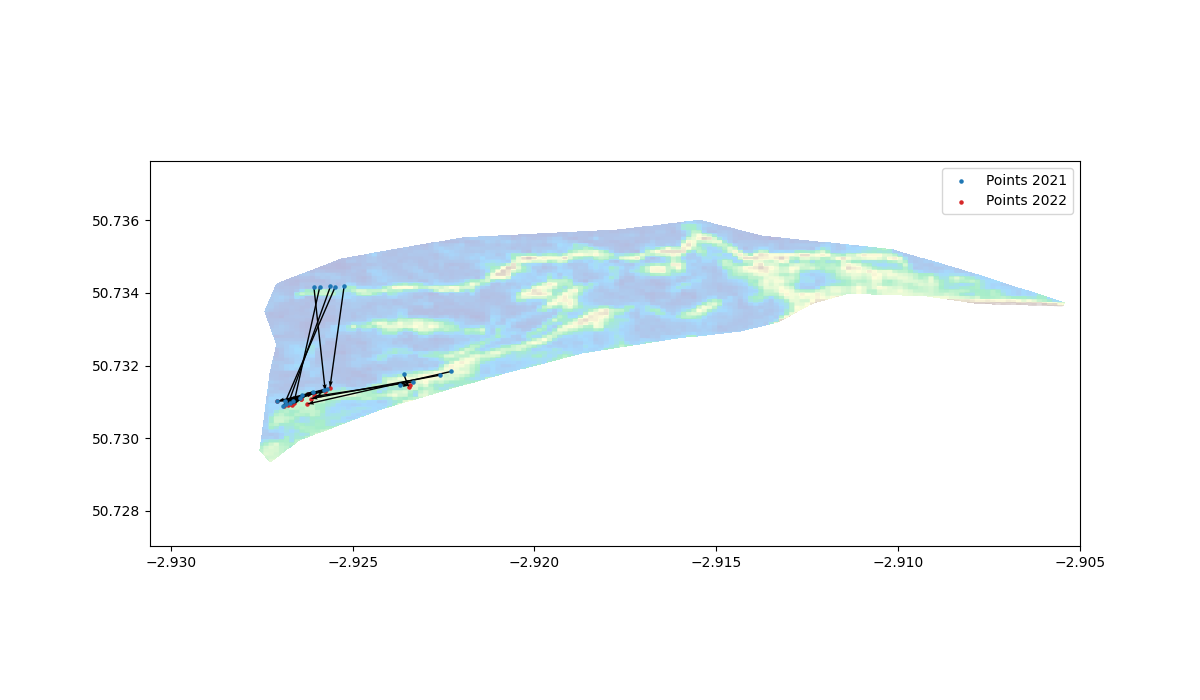

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap="terrain", alpha=0.35)

AB = ax.scatter(x1, y1, c = 'tab:blue', marker = '.', s = 20, zorder=2,label="Points 2021")
CD = ax.scatter(x2, y2, c = 'tab:red', marker = '.', s = 20, label="Points 2022")

ax.quiver(x1, y1, (x2-x1), (y2-y1), angles='xy', scale_units='xy', scale=1, width=0.0015)

plt.legend()
plt.show()

# Sensor data
The notebook cells below covers analysis of the sensor data located in Lyme Regis. The main two instruments that are being investigated is the IMU tables with accelerometer and rotation measurements.

! Important to note: next few lines can only be run with access to full data folder. To run the visualisation of sensor points, there is a import of single csv file that has already been filtered.

In [10]:
# Import the sensor key table
tagfile_path = "/content/drive/MyDrive/FINAL_project/ground_surveys/TagTypeLocation.csv"
tag_df = pd.read_csv(tagfile_path)

In [11]:
tag_df

,DevEUI,SENSUM ID,Location,Type
0,10CE45FFFE007769,201,Tebay,Miles Cobble
1,10CE45FFFE00776A,202,Plymouth lab/Alessandro,Miles Cobble
2,10CE45FFFE00776B,203,Plymouth lab/Alessandro,Miles Cobble
3,10CE45FFFE00776C,204,Plymouth lab/Alessandro,Miles Cobble
4,10CE45FFFE00776D,205,Plymouth lab/Alessandro,Miles Cobble
...,...,...,...,...
236,10CE45FFFE007855,437,Nepal/Bene,NaN
237,10CE45FFFE007856,438,Nepal/Bene,NaN
238,10CE45FFFE007857,439,Nepal/Bene,NaN
239,10CE45FFFE007858,440,Nepal/Bene,NaN


In [12]:
# Filter out the sensors in Lyme Regis
mask = tag_df["Location"].str.contains("Lyme Regis", case=False, na=False)
lyme_regis = tag_df[mask]

In [13]:
lyme_regis

,DevEUI,SENSUM ID,Location,Type
5,10CE45FFFE00776E,206,Lyme Regis,D cell
6,10CE45FFFE00776F,207,Lyme Regis,D cell
7,10CE45FFFE007770,208,Lyme Regis (Recovered),D cell
8,10CE45FFFE007771,209,Lyme Regis,D cell
9,10CE45FFFE007772,210,Lyme Regis,D cell
10,10CE45FFFE007773,211,Lyme Regis (Recovered),D cell
11,10CE45FFFE007774,212,Lyme Regis,D cell
12,10CE45FFFE007775,213,Lyme Regis,D cell
13,10CE45FFFE007776,214,Lyme Regis,D cell
14,10CE45FFFE007777,215,Lyme Regis (Recovered),D cell


In [14]:
# Get the devEUI ID list
file_names = lyme_regis["DevEUI"].tolist()
print(file_names)
print(len(file_names))

['10CE45FFFE00776E', '10CE45FFFE00776F', '10CE45FFFE007770', '10CE45FFFE007771', '10CE45FFFE007772', '10CE45FFFE007773', '10CE45FFFE007774', '10CE45FFFE007775', '10CE45FFFE007776', '10CE45FFFE007777', '10CE45FFFE007778', '10CE45FFFE007779', '10CE45FFFE00777A', '10CE45FFFE00777B', '10CE45FFFE00777C', '10CE45FFFE00777D', '10CE45FFFE00777E', '10CE45FFFE00777F', '10CE45FFFE007780', '10CE45FFFE007781', '10CE45FFFE007782', '10CE45FFFE007783', '10CE45FFFE007784', '10CE45FFFE007785', '10CE45FFFE007786', '10CE45FFFE00778A', '10CE45FFFE00778B', '10CE45FFFE00778E', '10CE45FFFE00778F', '10CE45FFFE007790', '10CE45FFFE007791', '10CE45FFFE007792', '10CE45FFFE007793', '10CE45FFFE007794', '10CE45FFFE007798', '10CE45FFFE007799', '10CE45FFFE0077C7', '10CE45FFFE0077C8', '10CE45FFFE0077C9', '10CE45FFFE0077CA', '10CE45FFFE0077CB']
41


### IMU file - 105

In [ ]:
## Filter the field data to access sensors records that are/have been in Lyme Regis
## Cell to run when all data CSV access
field_data_path = "/content/drive/MyDrive/FINAL_project/ground_surveys/Field_data"

files_dict = dict()
# Collect all the IMU data
imu_lst = []
for f in os.listdir(field_data_path):
    #Get the id for devEUI and file ext
    file_id, spec_id = f.rsplit(".", 1)[0].rsplit("_", 1)

    if file_id in file_names:
        if file_id in files_dict:
            files_dict[file_id].append(spec_id)
        else:
            files_dict.setdefault(file_id, [f])

        file_path = os.path.join(field_data_path, f)
        # Get only the IMU files and read in
        if spec_id == "105":
            with open(file_path, 'r') as file:
              f_csv = csv.reader(file)
              headers = next(f_csv)
              for row in f_csv:
                row.append(file_id)
                imu_lst.append(row)

files_dict

{'10CE45FFFE00776E': ['10CE45FFFE00776E_rx.csv',
  '105',
  '101',
  '103',
  '212',
  '107',
  '100',
  'txd'],
 '10CE45FFFE00777C': ['10CE45FFFE00777C_105.csv',
  'txd',
  'rx',
  '212',
  '107',
  '103',
  '100',
  '101',
  '104'],
 '10CE45FFFE007770': ['10CE45FFFE007770_rx.csv',
  '105',
  '100',
  '101',
  'txd',
  '107',
  '212',
  '103'],
 '10CE45FFFE007778': ['10CE45FFFE007778_txd.csv',
  'rx',
  '103',
  '100',
  '101',
  '212',
  '107',
  '105'],
 '10CE45FFFE007772': ['10CE45FFFE007772_105.csv',
  '103',
  '100',
  '101',
  'txd',
  '212',
  '107',
  'rx'],
 '10CE45FFFE007783': ['10CE45FFFE007783_rx.csv',
  'txd',
  '105',
  '212',
  '107',
  '103',
  '100',
  '101'],
 '10CE45FFFE007771': ['10CE45FFFE007771_txd.csv',
  '105',
  '212',
  'rx',
  '107',
  '103',
  '101',
  '100'],
 '10CE45FFFE00777F': ['10CE45FFFE00777F_txd.csv',
  'rx',
  '212',
  '107',
  '105',
  '103',
  '100',
  '101'],
 '10CE45FFFE00776F': ['10CE45FFFE00776F_100.csv',
  '101',
  '105',
  'rx',
  'txd',
  

In [ ]:
# Cell to run when access to filtered sensor data in sensor_data_lyme_regis.csv
sensor_path = "/content/drive/MyDrive/FINAL_project/ground_surveys/sensor_data_lyme_regis.csv"

imu_lst = []
with open(sensor_path, 'r') as file:
    f_csv = csv.reader(file)
    headers = next(f_csv)
    for row in f_csv:

        imu_lst.append(row)

imu_lst

[['2',
  '0',
  '0',
  '2021-10-07 00:42:09',
  '-3.4000000000000004',
  '-7.2',
  '1.3',
  '-5.63094',
  '8.05401',
  '1.72656',
  '1274894',
  '10CE45FFFE00776E'],
 ['2',
  '0',
  '0',
  '2021-10-07 00:42:09',
  '-3.4000000000000004',
  '-7.2',
  '1.3',
  '-5.63094',
  '8.05401',
  '1.72656',
  '1274909',
  '10CE45FFFE00776E'],
 ['2',
  '0',
  '0',
  '2021-10-07 00:42:09',
  '-3.4000000000000004',
  '-7.2',
  '1.3',
  '-5.63094',
  '8.05401',
  '1.72656',
  '1274921',
  '10CE45FFFE00776E'],
 ['2',
  '0',
  '0',
  '2021-10-07 00:42:09',
  '-3.4000000000000004',
  '-7.2',
  '1.3',
  '-5.63094',
  '8.05401',
  '1.72656',
  '1274934',
  '10CE45FFFE00776E'],
 ['2',
  '0',
  '1',
  '2021-10-07 00:42:09',
  '-43.0',
  '-41.7',
  '-26.5',
  '-4.139819999999999',
  '8.36793',
  '1.35378',
  '1274940',
  '10CE45FFFE00776E'],
 ['2',
  '0',
  '2',
  '2021-10-07 00:42:09',
  '-30.4',
  '28.9',
  '-71.60000000000001',
  '-3.42369',
  '8.77014',
  '1.0006199999999998',
  '1274946',
  '10CE45FFFE007

In [ ]:
# Create a dataframe
imu_df = pd.DataFrame(imu_lst, columns=["block_id", "block_size",	"element_id",	"rtc_datetime",	"rotation_x", "rotation_y", "rotation_z",	"acceleration_x",	"acceleration_y",	"acceleration_z",	"packet_id", "devEUI"])
imu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216807 entries, 0 to 216806
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   block_id        216807 non-null  object
 1   block_size      216807 non-null  object
 2   element_id      216807 non-null  object
 3   rtc_datetime    216807 non-null  object
 4   rotation_x      216807 non-null  object
 5   rotation_y      216807 non-null  object
 6   rotation_z      216807 non-null  object
 7   acceleration_x  216807 non-null  object
 8   acceleration_y  216807 non-null  object
 9   acceleration_z  216807 non-null  object
 10  packet_id       216807 non-null  object
 11  devEUI          216807 non-null  object
dtypes: object(12)
memory usage: 19.8+ MB


In [ ]:
## Convert the data type in the dataframe
imu_df["block_id"] = pd.to_numeric(imu_df["block_id"])
imu_df["block_size"] = pd.to_numeric(imu_df["block_size"])
imu_df["rotation_x"] = pd.to_numeric(imu_df["rotation_x"])
imu_df["rotation_y"] = pd.to_numeric(imu_df["rotation_y"])
imu_df["rotation_z"] = pd.to_numeric(imu_df["rotation_z"])
imu_df["acceleration_x"] = pd.to_numeric(imu_df["acceleration_x"])
imu_df["acceleration_y"] = pd.to_numeric(imu_df["acceleration_y"])
imu_df["acceleration_z"] = pd.to_numeric(imu_df["acceleration_z"])
imu_df["packet_id"] = pd.to_numeric(imu_df["packet_id"])
imu_df['rtc_datetime'] = pd.to_datetime(imu_df['rtc_datetime'], format='%Y-%m-%d %H:%M:%S.%f')
imu_df['devEUI'] = imu_df['devEUI'].astype(str)

In [ ]:
# Check the dataframe columns have correct dtype
imu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216807 entries, 0 to 216806
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   block_id        216807 non-null  int64         
 1   block_size      216807 non-null  int64         
 2   element_id      216807 non-null  object        
 3   rtc_datetime    216807 non-null  datetime64[ns]
 4   rotation_x      216807 non-null  float64       
 5   rotation_y      216807 non-null  float64       
 6   rotation_z      216807 non-null  float64       
 7   acceleration_x  216807 non-null  float64       
 8   acceleration_y  216807 non-null  float64       
 9   acceleration_z  216807 non-null  float64       
 10  packet_id       216807 non-null  int64         
 11  devEUI          216807 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 19.8+ MB


In [ ]:
## Check if the dataframe has any NaN values
imu_df.isnull().values.any()

False

In [ ]:
# Filter out invalid values (ie rows with 2000)
imu_df = imu_df[imu_df['rtc_datetime'].dt.strftime('%Y') > '2000'].reset_index(drop=True)
imu_df

,block_id,block_size,element_id,rtc_datetime,rotation_x,rotation_y,rotation_z,acceleration_x,acceleration_y,acceleration_z,packet_id,devEUI
0,2,0,0,2021-10-07 00:42:09,-3.4,-7.2,1.3,-5.63094,8.05401,1.72656,1274894,10CE45FFFE00776E
1,2,0,0,2021-10-07 00:42:09,-3.4,-7.2,1.3,-5.63094,8.05401,1.72656,1274909,10CE45FFFE00776E
2,2,0,0,2021-10-07 00:42:09,-3.4,-7.2,1.3,-5.63094,8.05401,1.72656,1274921,10CE45FFFE00776E
3,2,0,0,2021-10-07 00:42:09,-3.4,-7.2,1.3,-5.63094,8.05401,1.72656,1274934,10CE45FFFE00776E
4,2,0,1,2021-10-07 00:42:09,-43.0,-41.7,-26.5,-4.13982,8.36793,1.35378,1274940,10CE45FFFE00776E
...,...,...,...,...,...,...,...,...,...,...,...,...
216802,22,0,251,2023-03-24 20:15:18,2.1,1.8,6.0,0.28449,9.28026,2.36421,10379071,10CE45FFFE0077CB
216803,22,0,252,2023-03-24 20:15:18,2.1,1.8,6.0,0.25506,9.28026,2.38383,10379074,10CE45FFFE0077CB
216804,22,0,253,2023-03-24 20:15:18,2.1,1.8,6.0,0.25506,9.30969,2.35440,10379077,10CE45FFFE0077CB
216805,22,0,254,2023-03-24 20:15:18,2.0,1.8,6.0,0.24525,9.27045,2.37402,10379083,10CE45FFFE0077CB


In [ ]:
## Get unique values of devEUI ids
unique_id = imu_df["devEUI"].unique()

### Accelemeter

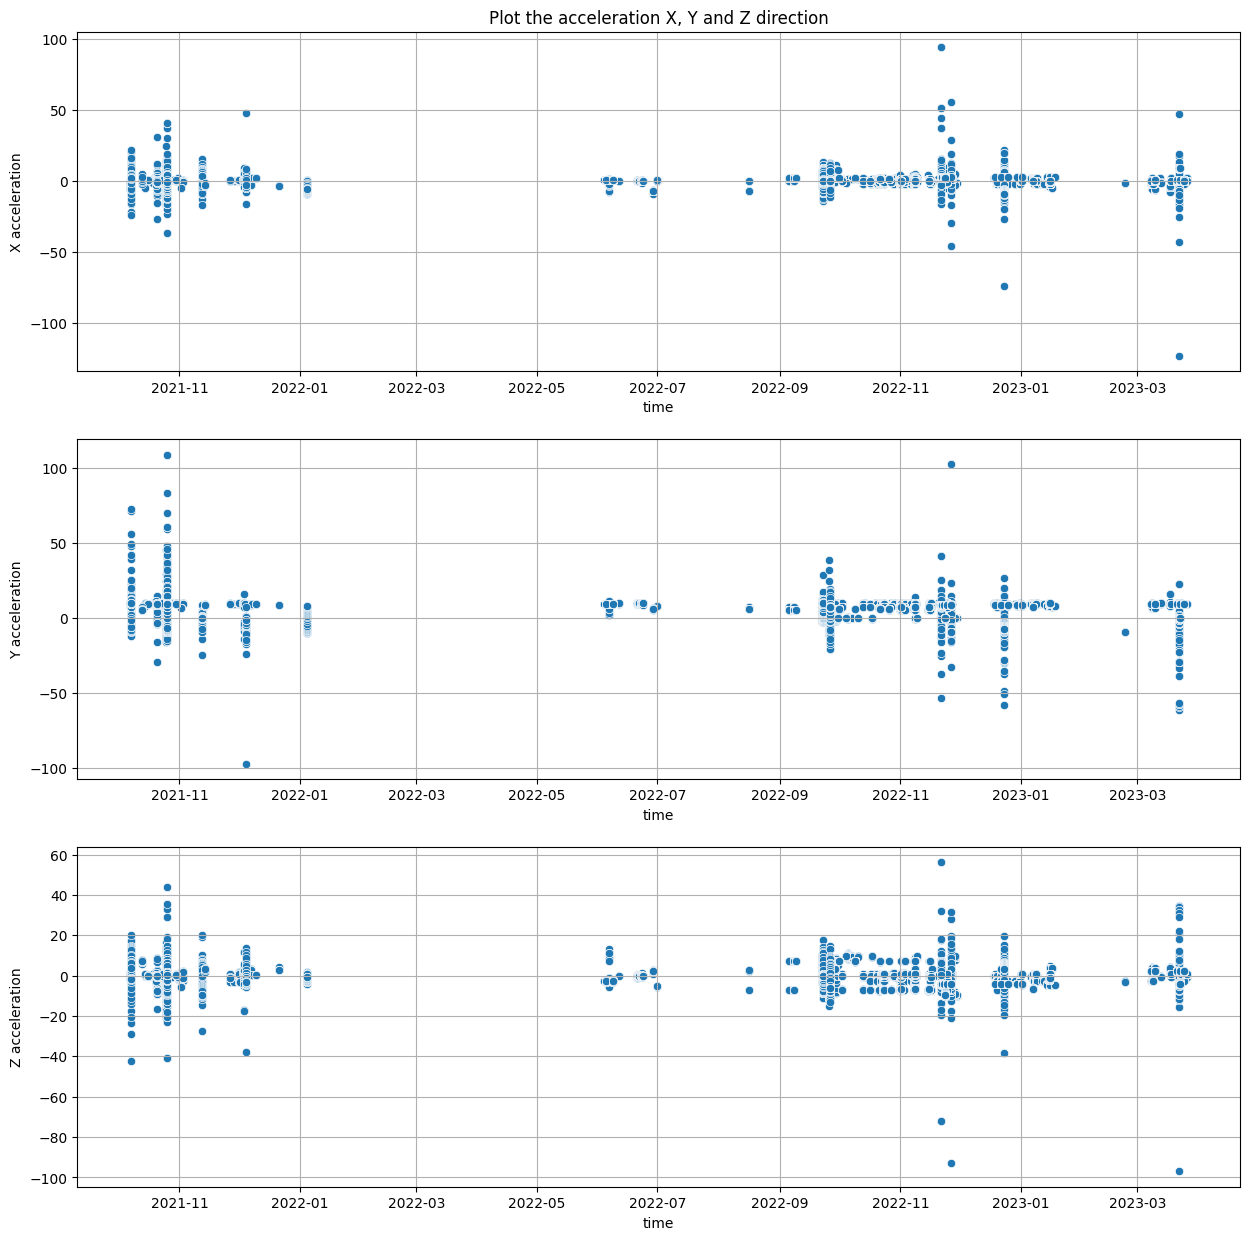

In [ ]:
# Plot acceleration data against the whole time range
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.scatterplot(x='rtc_datetime', y='acceleration_x', data=imu_df, ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('X acceleration')
axs[0].grid()

sns.scatterplot(x='rtc_datetime', y='acceleration_y', data=imu_df, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('Y acceleration')
axs[1].grid()

sns.scatterplot(x='rtc_datetime', y='acceleration_z', data=imu_df, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('Z acceleration')
axs[2].grid()

axs[0].set_title('Plot the acceleration X, Y and Z direction')
plt.savefig("/content/drive/MyDrive/FINAL_project/ground_surveys/all_range_acceleration.png")
plt.show()

In [ ]:
## For each devEUI ID plot the timeseries of acceleration
for id in unique_id:
    temp_df = imu_df[imu_df['devEUI'] == id]
    print(temp_df)
    f, axs = plt.subplots(3, 1, figsize=(15, 15))

    axs[0].plot(temp_df.rtc_datetime, temp_df.acceleration_x, '.')
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('X acceleration')
    axs[0].grid()

    axs[1].plot(temp_df.rtc_datetime, temp_df.acceleration_y, '.')
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('Y acceleration')
    axs[1].grid()

    axs[2].plot(temp_df.rtc_datetime, temp_df.acceleration_z, '.')
    axs[2].set_xlabel('time')
    axs[2].set_ylabel('Z acceleration')
    axs[2].grid()

    axs[0].set_title(f'Plot the acceleration X, Y and Z direction for {id}')
    plt.savefig(f"/content/drive/MyDrive/FINAL_project/ground_surveys/plot_accelemeter_devEUI/{id}.png")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Filter out first day (ie rows with 2021-10-07)
fimu_df = imu_df[imu_df['rtc_datetime'].dt.strftime('%Y-%m-%d') > '2021-10-07']#.reset_index(drop=True)
fimu_df

,block_id,block_size,element_id,rtc_datetime,rotation_x,rotation_y,rotation_z,acceleration_x,acceleration_y,acceleration_z,packet_id,devEUI
513,1,0,0,2021-10-25 10:44:05,-3.9,2.9,0.7,-0.23544,10.03563,-5.58189,1385229,10CE45FFFE00777C
514,1,0,1,2021-10-25 10:44:05,-31.9,137.3,-84.6,-5.10120,12.66471,-5.67018,1385247,10CE45FFFE00777C
515,1,0,2,2021-10-25 10:44:05,-93.5,198.8,-279.4,4.54203,8.82900,-6.48441,1385265,10CE45FFFE00777C
516,1,0,3,2021-10-25 10:44:05,-168.3,51.4,-228.4,4.50279,5.39550,-6.61194,1385286,10CE45FFFE00777C
517,1,0,4,2021-10-25 10:44:05,-255.3,17.1,-170.6,4.79709,6.12144,-6.61194,1385304,10CE45FFFE00777C
...,...,...,...,...,...,...,...,...,...,...,...,...
216802,22,0,251,2023-03-24 20:15:18,2.1,1.8,6.0,0.28449,9.28026,2.36421,10379071,10CE45FFFE0077CB
216803,22,0,252,2023-03-24 20:15:18,2.1,1.8,6.0,0.25506,9.28026,2.38383,10379074,10CE45FFFE0077CB
216804,22,0,253,2023-03-24 20:15:18,2.1,1.8,6.0,0.25506,9.30969,2.35440,10379077,10CE45FFFE0077CB
216805,22,0,254,2023-03-24 20:15:18,2.0,1.8,6.0,0.24525,9.27045,2.37402,10379083,10CE45FFFE0077CB


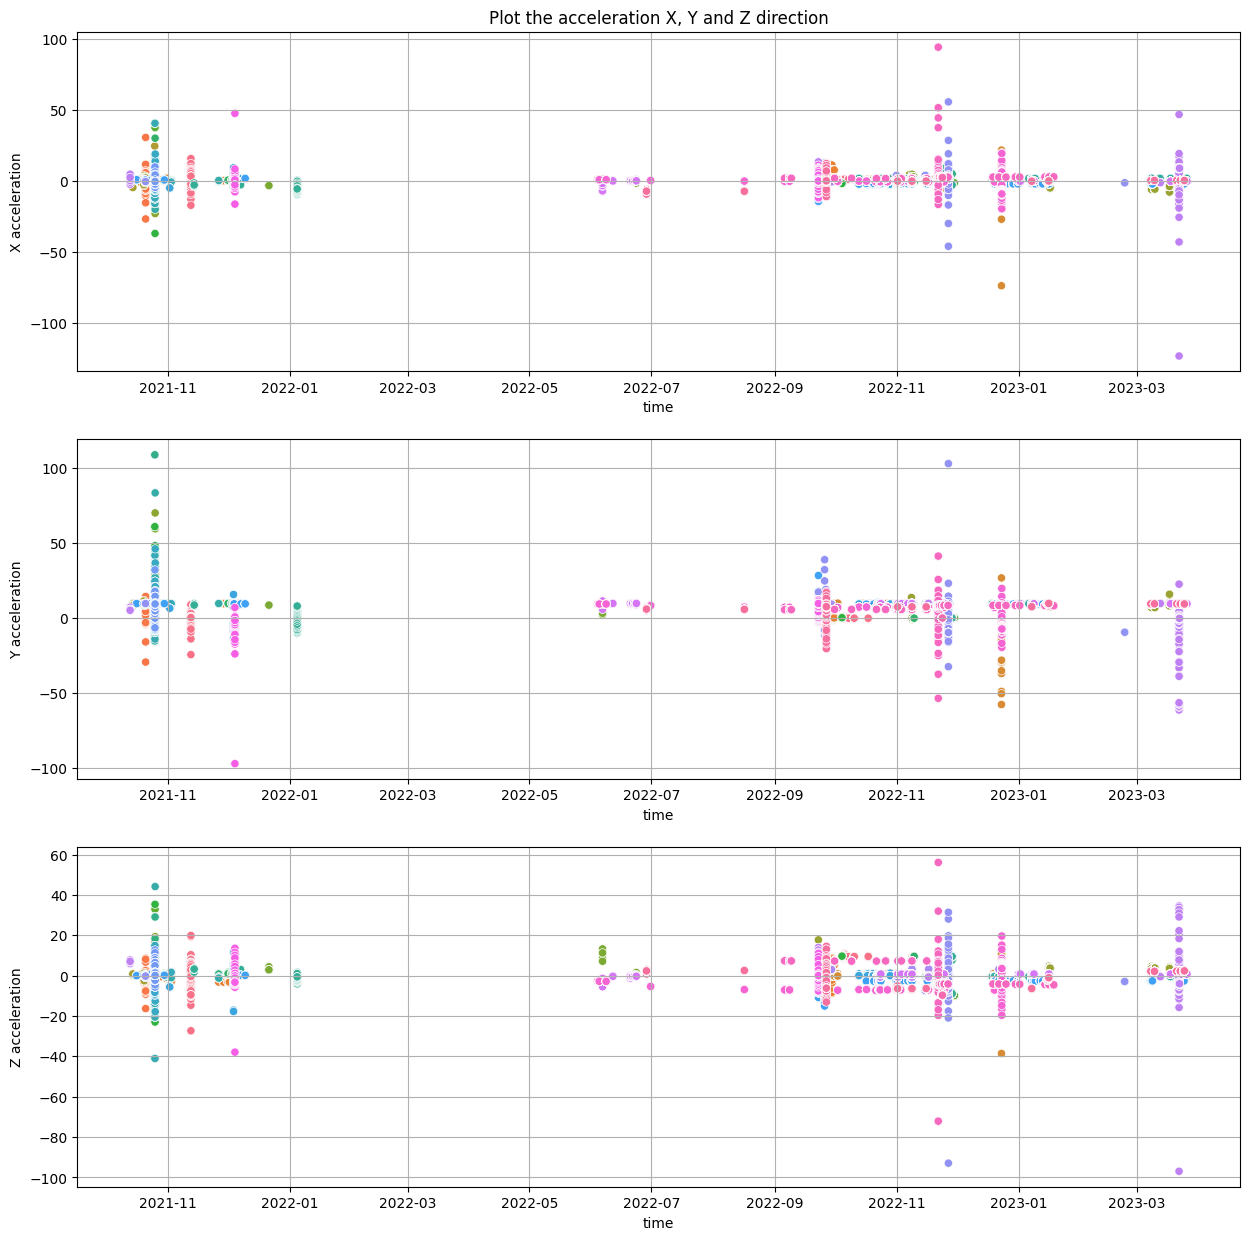

In [ ]:
# Plot acceleration data against the whole time range without day 1
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.scatterplot(x='rtc_datetime', y='acceleration_x', hue='devEUI', legend=False, data=fimu_df, ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('X acceleration')
axs[0].grid()

sns.scatterplot(x='rtc_datetime', y='acceleration_y', hue='devEUI', legend=False, data=fimu_df, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('Y acceleration')
axs[1].grid()

sns.scatterplot(x='rtc_datetime', y='acceleration_z', hue='devEUI', legend=False, data=fimu_df, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('Z acceleration')
axs[2].grid()

axs[0].set_title('Plot the acceleration X, Y and Z direction')
plt.savefig("/content/drive/MyDrive/FINAL_project/ground_surveys/all_except_day1_acceleration.png")
plt.show()

In [ ]:
## Get unique values of date ids
unique_rtc_id = fimu_df.rtc_datetime.dt.date.unique()

In [ ]:
unique_rtc_id

array([datetime.date(2021, 10, 25), datetime.date(2021, 10, 30),
       datetime.date(2021, 11, 12), datetime.date(2022, 10, 5),
       datetime.date(2022, 10, 7), datetime.date(2022, 10, 10),
       datetime.date(2022, 10, 17), datetime.date(2021, 10, 19),
       datetime.date(2021, 10, 20), datetime.date(2021, 10, 18),
       datetime.date(2021, 10, 28), datetime.date(2021, 10, 31),
       datetime.date(2021, 11, 2), datetime.date(2021, 11, 26),
       datetime.date(2021, 11, 28), datetime.date(2021, 12, 1),
       datetime.date(2022, 9, 29), datetime.date(2022, 9, 30),
       datetime.date(2022, 9, 25), datetime.date(2022, 10, 2),
       datetime.date(2022, 10, 12), datetime.date(2022, 10, 14),
       datetime.date(2022, 10, 19), datetime.date(2022, 10, 21),
       datetime.date(2022, 10, 23), datetime.date(2022, 10, 27),
       datetime.date(2022, 10, 31), datetime.date(2022, 11, 1),
       datetime.date(2022, 11, 2), datetime.date(2022, 11, 3),
       datetime.date(2022, 11, 5), d

In [ ]:
for date_id in unique_rtc_id:

    temp_df = fimu_df[fimu_df['rtc_datetime'].dt.date == date_id]
    print(temp_df)
    rel = sns.pairplot(temp_df[["acceleration_x", "acceleration_y", "acceleration_z","devEUI"]], hue='devEUI')
    rel.fig.subplots_adjust(top=.9)
    rel.fig.suptitle(f"Accelemeter movement on {date_id}")
    plt.savefig(f"/content/drive/MyDrive/FINAL_project/ground_surveys/plot_accelemeter_dates/plot_accelemeter_{date_id}.png")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## Group the record by devEUI and upsampled datetime with freq=D
grouped_imu = fimu_df.groupby([pd.Grouper(key='rtc_datetime', freq='D'), 'devEUI'])[["acceleration_x", "acceleration_y", "acceleration_z", "rotation_x", "rotation_y", "rotation_z"]].mean()

In [ ]:
grouped_imu

acceleration_x  acceleration_y  acceleration_z  \
rtc_datetime devEUI                                                             
2021-10-13   10CE45FFFE007790        1.133055        5.664294        7.168167   
2021-10-14   10CE45FFFE007775       -3.442084        8.678171        0.446355   
2021-10-16   10CE45FFFE007799        0.767632        9.515700        0.014715   
2021-10-18   10CE45FFFE007770        0.553564        9.781971       -0.196200   
             10CE45FFFE007774       -1.212236        9.411994        0.592804   
...                                       ...             ...             ...   
2023-03-24   10CE45FFFE007799       -2.179314        9.145679       -2.638277   
             10CE45FFFE0077CB        0.275943        9.291397        2.334231   
2023-03-25   10CE45FFFE00778E       -0.265544        9.428047        0.745860   
             10CE45FFFE007791        1.791208        9.529140       -0.517576   
2023-03-26   10CE45FFFE00778E       -0.256085        9.414525        0.754748   

                               rotation_x  rotation_y  rotation_z  
rtc_datetime devEUI                                                
2021-10-13   10CE45FFFE007790   15.810000   -7.740000    4.180000  
2021-10-14   10CE45FFFE007775    9.050000    3.187500   33.887500  
2021-10-16   10CE45FFFE007799    5.225000   -2.000000    0.825000  
2021-10-18   10CE45FFFE007770    7.114286    8.700000    3.885714  
             10CE45FFFE007774    0.685714    0.928571    2.057143  
...                                   ...         ...         ...  
2023-03-24   10CE45FFFE007799   -0.960938    3.247656    3.578125  
             10CE45FFFE0077CB    2.099220    1.665150    6.349285  
2023-03-25   10CE45FFFE00778E    1.456107    0.858015   -0.645420  
             10CE45FFFE007791    0.821000    1.851000    1.265000  
2023-03-26   10CE45FFFE00778E    1.613806    1.445149   -0.676493  

[315 rows x 6 columns]

In [ ]:
grouped_imu = grouped_imu.reset_index()

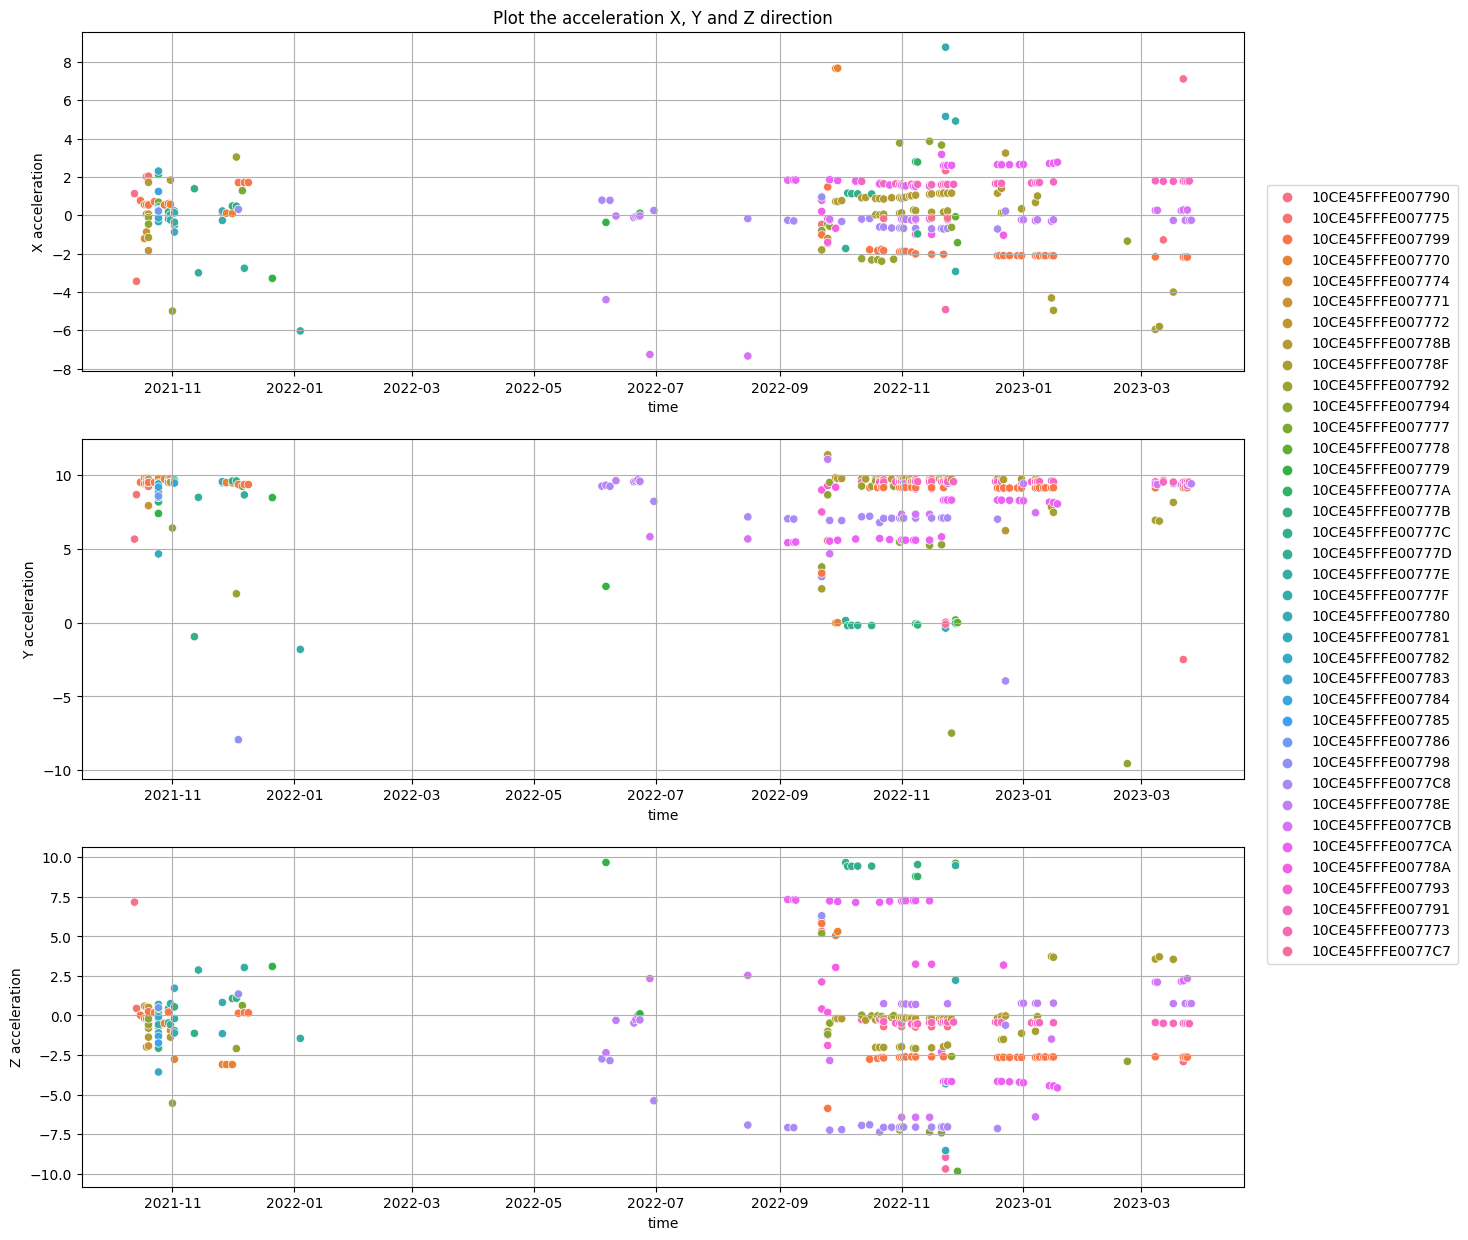

In [ ]:
# Plot acceleration data against the whole time range after resampling
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.scatterplot(x='rtc_datetime', y='acceleration_x', hue='devEUI', legend=True, data=grouped_imu, ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('X acceleration')
axs[0].grid()

sns.scatterplot(x='rtc_datetime', y='acceleration_y', hue='devEUI', legend=True, data=grouped_imu, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('Y acceleration')
axs[1].grid()

sns.scatterplot(x='rtc_datetime', y='acceleration_z', hue='devEUI', legend=True, data=grouped_imu, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('Z acceleration')
axs[2].grid()

axs[0].set_title('Plot the acceleration X, Y and Z direction')
axs[0].legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
axs[1].get_legend().remove()
axs[2].get_legend().remove()
plt.savefig("/content/drive/MyDrive/FINAL_project/ground_surveys/resample_freq_D_acceleration.png")
plt.show()

### Rotation

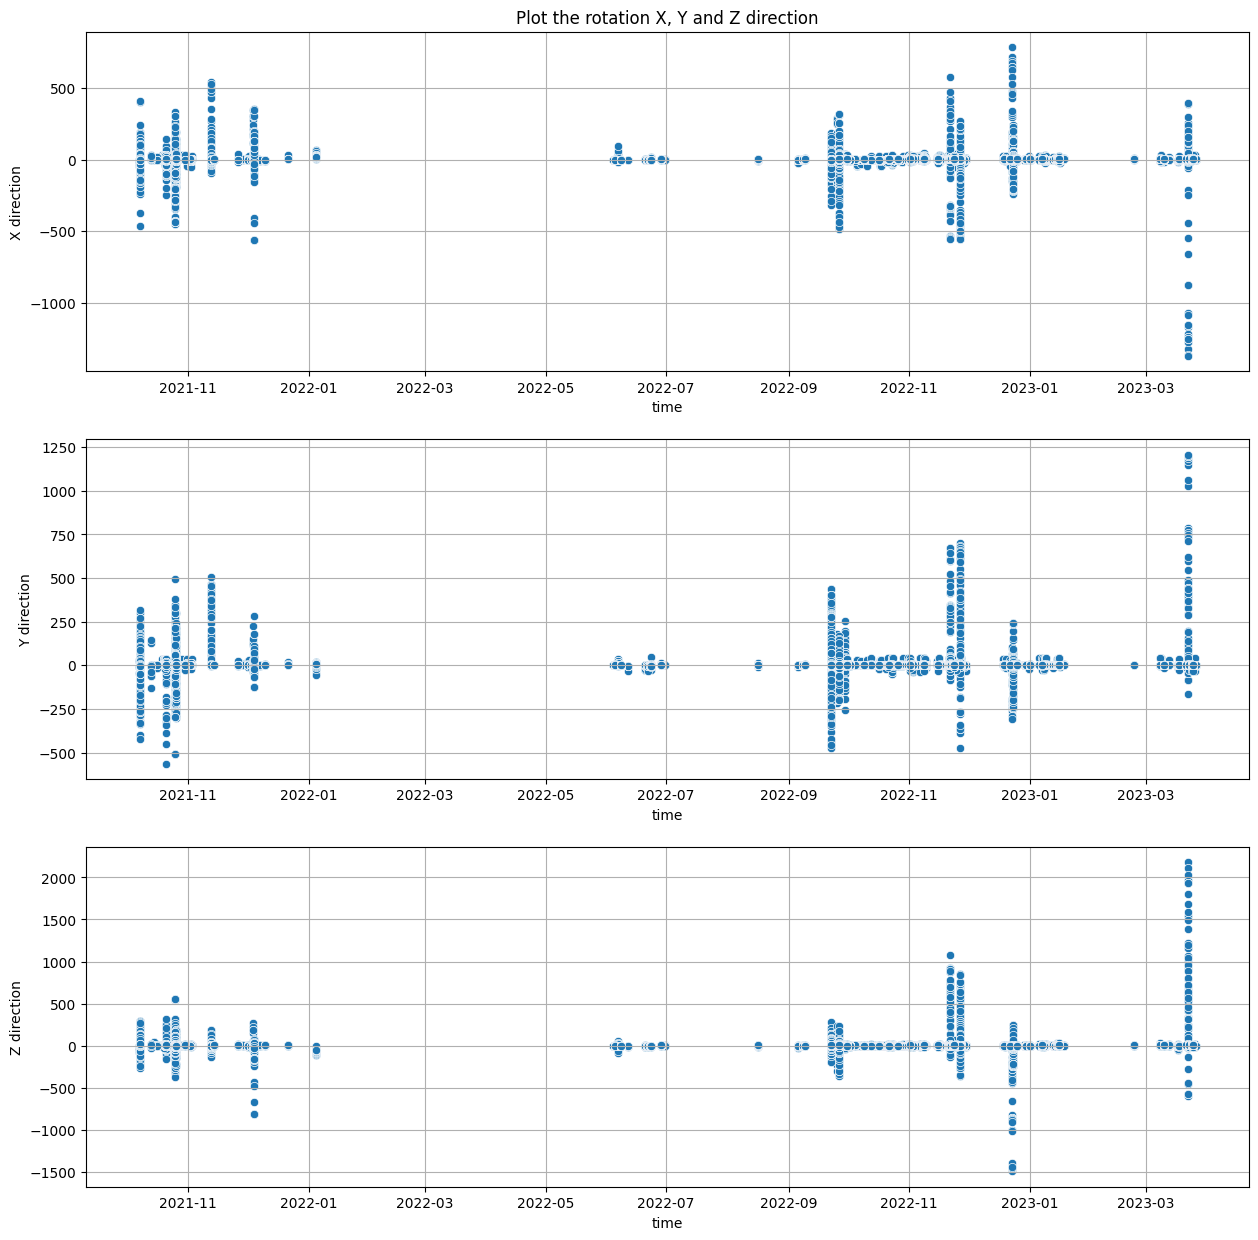

In [ ]:
# Plot acceleration data against the whole time range
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.scatterplot(x='rtc_datetime', y='rotation_x', data=imu_df, ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('X direction')
axs[0].grid()

sns.scatterplot(x='rtc_datetime', y='rotation_y', data=imu_df, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('Y direction')
axs[1].grid()

sns.scatterplot(x='rtc_datetime', y='rotation_z', data=imu_df, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('Z direction')
axs[2].grid()

axs[0].set_title('Plot the rotation X, Y and Z direction')
plt.savefig("/content/drive/MyDrive/FINAL_project/ground_surveys/all_range_rotation.png")
plt.show()

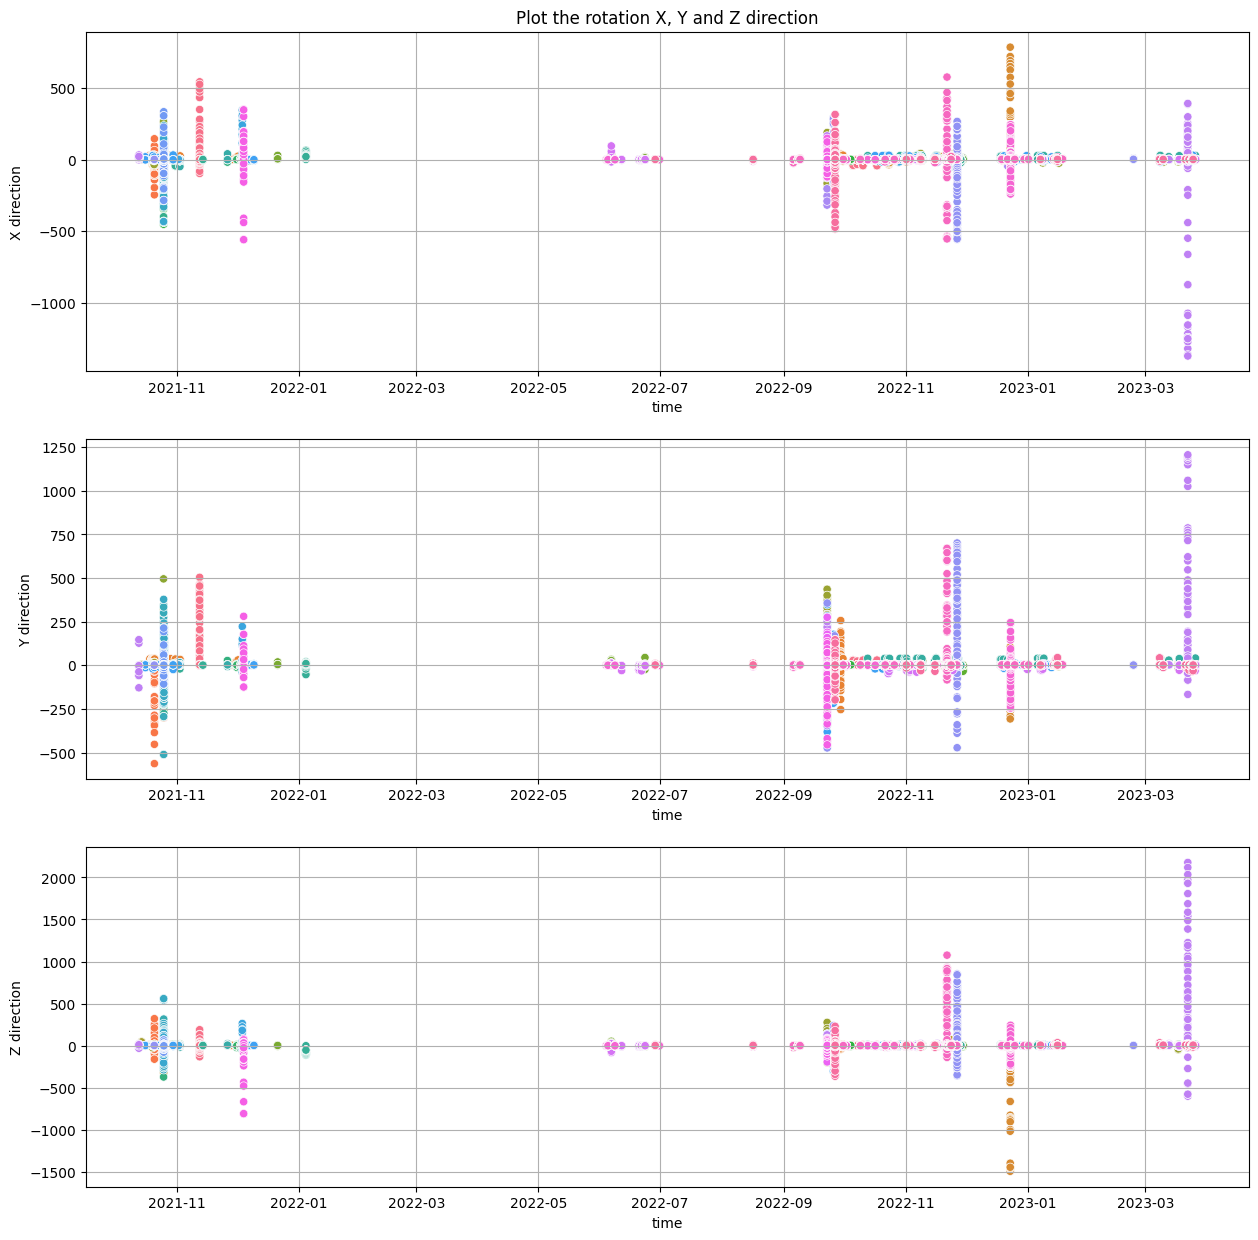

In [ ]:
# Plot acceleration data against the whole time range without day 1
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.scatterplot(x='rtc_datetime', y='rotation_x', hue='devEUI', legend=False, data=fimu_df, ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('X direction')
axs[0].grid()

sns.scatterplot(x='rtc_datetime', y='rotation_y', hue='devEUI', legend=False, data=fimu_df, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('Y direction')
axs[1].grid()

sns.scatterplot(x='rtc_datetime', y='rotation_z', hue='devEUI', legend=False, data=fimu_df, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('Z direction')
axs[2].grid()

axs[0].set_title('Plot the rotation X, Y and Z direction')
plt.savefig("/content/drive/MyDrive/FINAL_project/ground_surveys/all_except_day1_rotation.png")
plt.show()

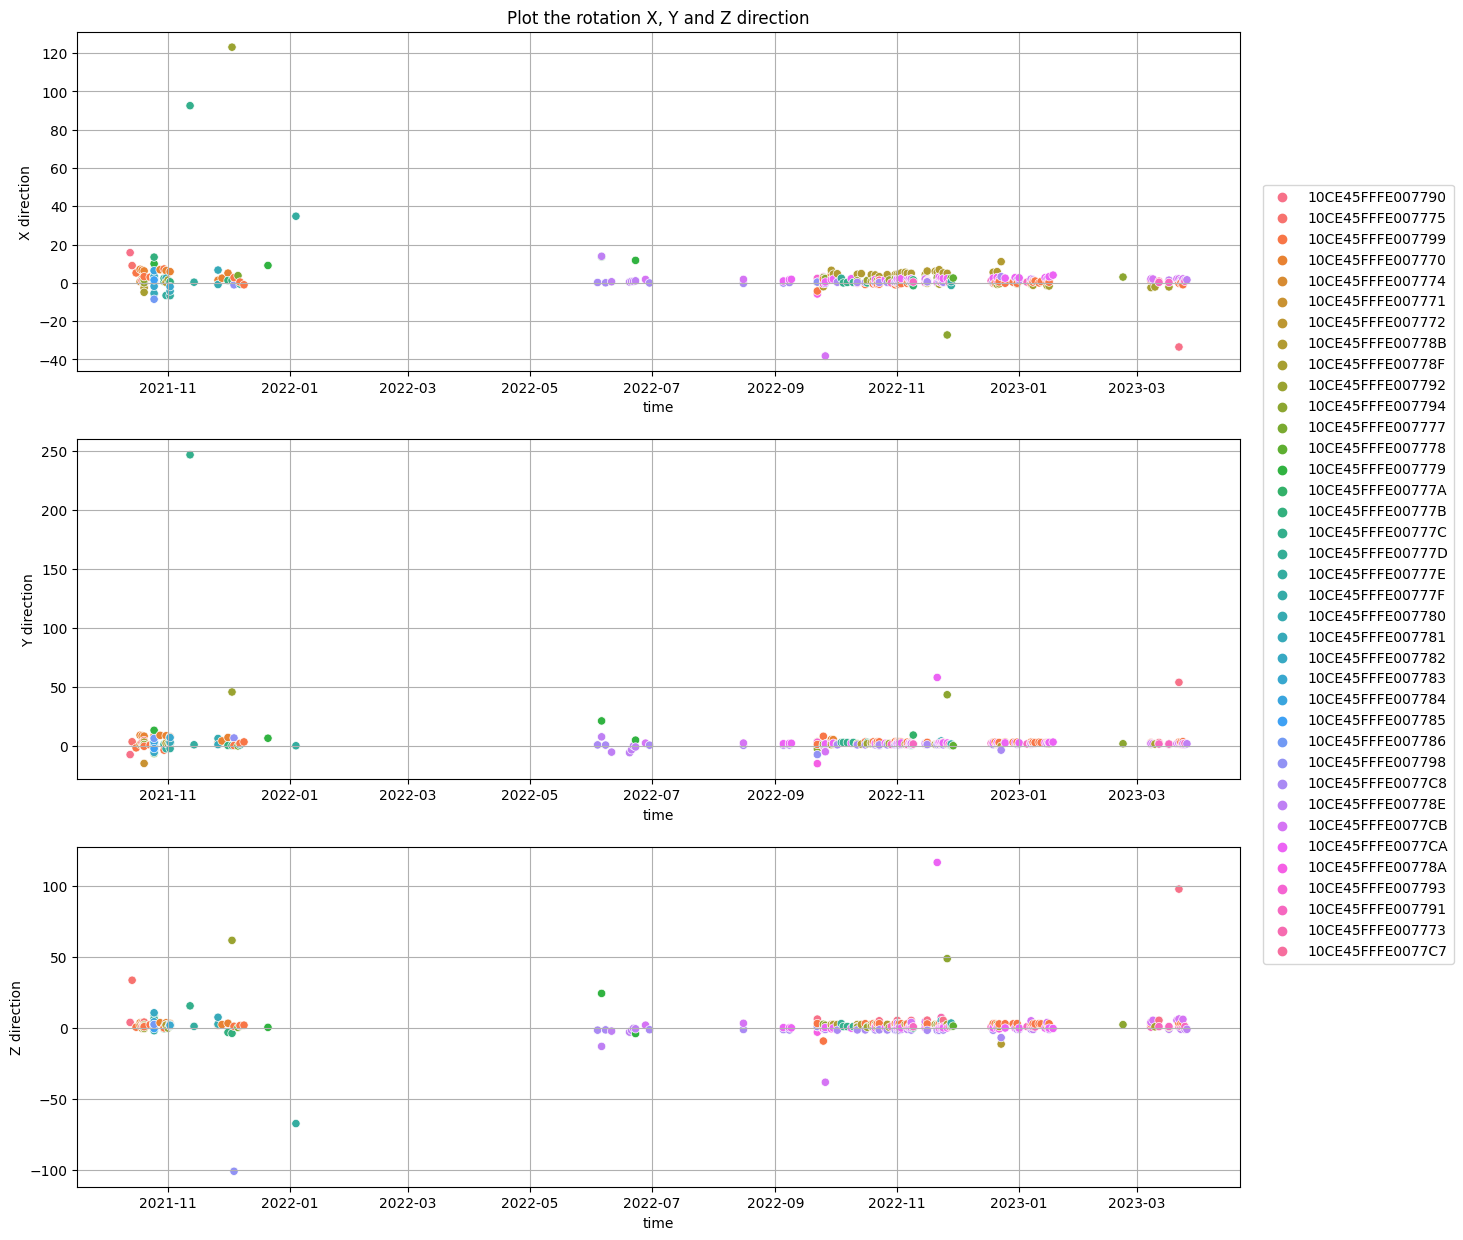

In [ ]:
# Plot acceleration data against the whole time range after resampling
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.scatterplot(x='rtc_datetime', y='rotation_x', hue='devEUI', legend=True, data=grouped_imu, ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('X direction')
axs[0].grid()

sns.scatterplot(x='rtc_datetime', y='rotation_y', hue='devEUI', legend=True, data=grouped_imu, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('Y direction')
axs[1].grid()

sns.scatterplot(x='rtc_datetime', y='rotation_z', hue='devEUI', legend=True, data=grouped_imu, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('Z direction')
axs[2].grid()

axs[0].set_title('Plot the rotation X, Y and Z direction')
axs[0].legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
axs[1].get_legend().remove()
axs[2].get_legend().remove()
plt.savefig("/content/drive/MyDrive/FINAL_project/ground_surveys/resample_freq_D_rotation.png")
plt.show()

In [ ]:
grouped_imu.describe()

,acceleration_x,acceleration_y,acceleration_z,rotation_x,rotation_y,rotation_z
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000
mean,0.189502,7.846863,-0.490501,2.053537,2.896900,2.069184
std,1.994444,3.213062,3.774708,9.836897,15.131520,12.455581
min,-7.340371,-9.558841,-9.853855,-38.167123,-15.409712,-100.654717
25%,-0.661368,7.280892,-2.620140,0.191516,0.798241,0.242644
50%,0.172991,9.254367,-0.452793,1.144407,1.490734,1.339152
75%,1.519686,9.559624,0.568017,2.478625,2.478734,2.972094
max,8.777928,11.379600,9.678266,123.157895,247.037662,116.810332


In [ ]:
## For each devEUI ID plot the timeseries of acceleration
for id in unique_id:
    temp_df = grouped_imu[grouped_imu['devEUI'] == id]

    if not temp_df.empty:
        print(id)
        print(temp_df.describe())
        f, axs = plt.subplots(3, 1, figsize=(15, 15))

        axs[0].plot(temp_df.rtc_datetime, temp_df.acceleration_x, 'o')
        axs[0].set_xlabel('time')
        axs[0].set_ylabel('X direction')
        axs[0].grid()

        axs[1].plot(temp_df.rtc_datetime, temp_df.acceleration_y, 'o')
        axs[1].set_xlabel('time')
        axs[1].set_ylabel('Y direction')
        axs[1].grid()

        axs[2].plot(temp_df.rtc_datetime, temp_df.acceleration_z, 'o')
        axs[2].set_xlabel('time')
        axs[2].set_ylabel('Z direction')
        axs[2].grid()

        axs[0].set_title(f'Plot the acceleration X, Y and Z direction for {id}')
        plt.savefig(f"/content/drive/MyDrive/FINAL_project/ground_surveys/plot_accelemeter_devEUI_resample/{id}.png")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Save the grouped by DataFrame
grouped_imu.to_csv("/content/drive/MyDrive/FINAL_project/ground_surveys/resampled_IMU.csv")

In [ ]:
# Save the full IMU dataset
imu_df.to_csv("/content/drive/MyDrive/FINAL_project/ground_surveys/sensor_data_lyme_regis.csv", index=False)

### Accelerometer file - 104

In [17]:
## Filter the field data to access sensors records that are/have been in Lyme Regis
## Cell to run when all data CSV access
field_data_path = "/content/drive/MyDrive/FINAL_project/ground_surveys/Field_data"

files_dict = dict()
# Collect all the IMU data
acc_lst = []
for f in os.listdir(field_data_path):
    #Get the id for devEUI and file ext
    file_id, spec_id = f.rsplit(".", 1)[0].rsplit("_", 1)

    if file_id in file_names:
        if file_id in files_dict:
            files_dict[file_id].append(spec_id)
        else:
            files_dict.setdefault(file_id, [f])

        file_path = os.path.join(field_data_path, f)
        # Get only the Accelerometer  files and read in
        if spec_id == "104":
            with open(file_path, 'r') as file:
              f_csv = csv.reader(file)
              headers = next(f_csv)
              for row in f_csv:
                row.append(file_id)
                acc_lst.append(row)

files_dict

{'10CE45FFFE007799': ['10CE45FFFE007799_107.csv',
  'txd',
  'rx',
  '105',
  '103',
  '220',
  '101',
  '100',
  '212'],
 '10CE45FFFE007798': ['10CE45FFFE007798_212.csv',
  'rx',
  '103',
  'txd',
  '107',
  '100',
  '105',
  '101'],
 '10CE45FFFE0077C7': ['10CE45FFFE0077C7_212.csv',
  '101',
  '104',
  '100',
  '105',
  'rx',
  'txd'],
 '10CE45FFFE0077CA': ['10CE45FFFE0077CA_105.csv',
  'rx',
  '101',
  '212',
  'txd',
  '100'],
 '10CE45FFFE0077C9': ['10CE45FFFE0077C9_101.csv',
  '100',
  'txd',
  '104',
  'rx',
  '212'],
 '10CE45FFFE0077C8': ['10CE45FFFE0077C8_101.csv',
  '105',
  '212',
  '100',
  'txd',
  'rx'],
 '10CE45FFFE0077CB': ['10CE45FFFE0077CB_105.csv',
  '101',
  '212',
  '107',
  '100',
  'txd',
  'rx'],
 '10CE45FFFE00776E': ['10CE45FFFE00776E_101.csv',
  'rx',
  '103',
  '100',
  '107',
  'txd',
  '212',
  '105'],
 '10CE45FFFE00776F': ['10CE45FFFE00776F_101.csv',
  '105',
  '212',
  '107',
  '103',
  '100',
  'txd',
  'rx'],
 '10CE45FFFE007772': ['10CE45FFFE007772_103.cs

In [21]:
# Create a dataframe
acc_df = pd.DataFrame(acc_lst, columns=["block_id", "block_size",	"element_id",	"rtc_datetime", "acceleration_x",	"acceleration_y",	"acceleration_z",	"packet_id", "devEUI"])
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23828 entries, 0 to 23827
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   block_id        23828 non-null  object
 1   block_size      23828 non-null  object
 2   element_id      23828 non-null  object
 3   rtc_datetime    23828 non-null  object
 4   acceleration_x  23828 non-null  object
 5   acceleration_y  23828 non-null  object
 6   acceleration_z  23828 non-null  object
 7   packet_id       23828 non-null  object
 8   devEUI          23828 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


In [22]:
## Convert the data type in the dataframe
acc_df["block_id"] = pd.to_numeric(acc_df["block_id"])
acc_df["block_size"] = pd.to_numeric(acc_df["block_size"])
acc_df["acceleration_x"] = pd.to_numeric(acc_df["acceleration_x"])
acc_df["acceleration_y"] = pd.to_numeric(acc_df["acceleration_y"])
acc_df["acceleration_z"] = pd.to_numeric(acc_df["acceleration_z"])
acc_df["packet_id"] = pd.to_numeric(acc_df["packet_id"])
acc_df['rtc_datetime'] = pd.to_datetime(acc_df['rtc_datetime'], format='%Y-%m-%d %H:%M:%S.%f')
acc_df['devEUI'] = acc_df['devEUI'].astype(str)

In [23]:
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23828 entries, 0 to 23827
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   block_id        23828 non-null  int64         
 1   block_size      23828 non-null  int64         
 2   element_id      23828 non-null  object        
 3   rtc_datetime    23828 non-null  datetime64[ns]
 4   acceleration_x  23828 non-null  float64       
 5   acceleration_y  23828 non-null  float64       
 6   acceleration_z  23828 non-null  float64       
 7   packet_id       23828 non-null  int64         
 8   devEUI          23828 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 1.6+ MB


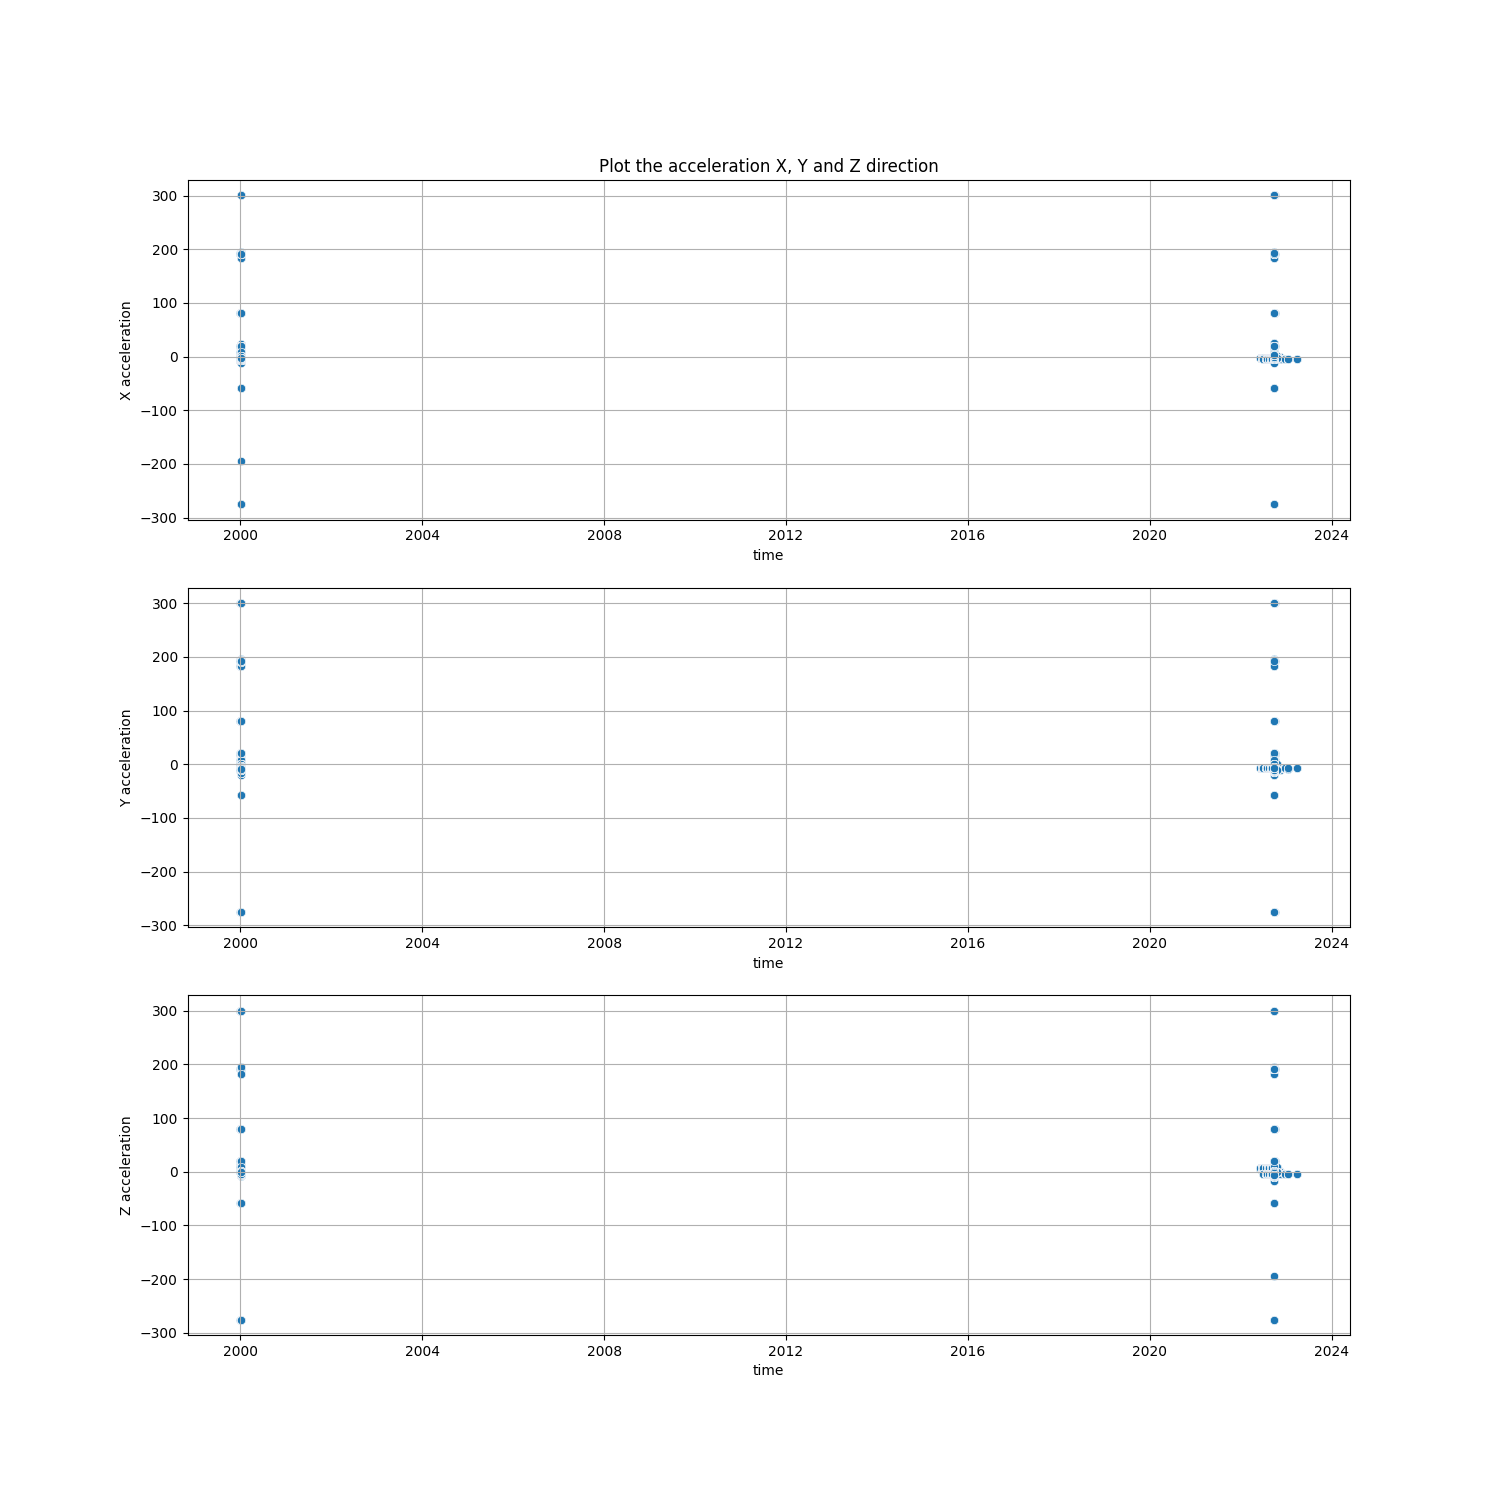

In [24]:
# Plot acceleration data against the whole time range
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.scatterplot(x='rtc_datetime', y='acceleration_x', data=acc_df, ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('X acceleration')
axs[0].grid()

sns.scatterplot(x='rtc_datetime', y='acceleration_y', data=acc_df, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('Y acceleration')
axs[1].grid()

sns.scatterplot(x='rtc_datetime', y='acceleration_z', data=acc_df, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('Z acceleration')
axs[2].grid()

axs[0].set_title('Plot the acceleration X, Y and Z direction')
#plt.savefig("/content/drive/MyDrive/Research_project/ground_surveys/all_range_acceleration_104.png")
plt.show()

### Magnetometer file - 107

In [26]:
## Filter the field data to access sensors records that are/have been in Lyme Regis
## Cell to run when all data CSV access
field_data_path = "/content/drive/MyDrive/FINAL_project/ground_surveys/Field_data"

files_dict = dict()
# Collect all the IMU data
mag_lst = []
for f in os.listdir(field_data_path):
    #Get the id for devEUI and file ext
    file_id, spec_id = f.rsplit(".", 1)[0].rsplit("_", 1)

    if file_id in file_names:
        if file_id in files_dict:
            files_dict[file_id].append(spec_id)
        else:
            files_dict.setdefault(file_id, [f])

        file_path = os.path.join(field_data_path, f)
        # Get only the MAgnometer files and read in
        if spec_id == "107":
            with open(file_path, 'r') as file:
              f_csv = csv.reader(file)
              headers = next(f_csv)
              for row in f_csv:
                row.append(file_id)
                mag_lst.append(row)

files_dict

{'10CE45FFFE007799': ['10CE45FFFE007799_107.csv',
  'txd',
  'rx',
  '105',
  '103',
  '220',
  '101',
  '100',
  '212'],
 '10CE45FFFE007798': ['10CE45FFFE007798_212.csv',
  'rx',
  '103',
  'txd',
  '107',
  '100',
  '105',
  '101'],
 '10CE45FFFE0077C7': ['10CE45FFFE0077C7_212.csv',
  '101',
  '104',
  '100',
  '105',
  'rx',
  'txd'],
 '10CE45FFFE0077CA': ['10CE45FFFE0077CA_105.csv',
  'rx',
  '101',
  '212',
  'txd',
  '100'],
 '10CE45FFFE0077C9': ['10CE45FFFE0077C9_101.csv',
  '100',
  'txd',
  '104',
  'rx',
  '212'],
 '10CE45FFFE0077C8': ['10CE45FFFE0077C8_101.csv',
  '105',
  '212',
  '100',
  'txd',
  'rx'],
 '10CE45FFFE0077CB': ['10CE45FFFE0077CB_105.csv',
  '101',
  '212',
  '107',
  '100',
  'txd',
  'rx'],
 '10CE45FFFE00776E': ['10CE45FFFE00776E_101.csv',
  'rx',
  '103',
  '100',
  '107',
  'txd',
  '212',
  '105'],
 '10CE45FFFE00776F': ['10CE45FFFE00776F_101.csv',
  '105',
  '212',
  '107',
  '103',
  '100',
  'txd',
  'rx'],
 '10CE45FFFE007772': ['10CE45FFFE007772_103.cs

In [27]:
# Create a dataframe
mag_df = pd.DataFrame(imu_lst, columns=["block_id", "block_size",	"element_id",	"rtc_datetime",	"magnetometer_x",	"magnetometer_y",	"magnetometer_z",	"packet_id", "devEUI"])
mag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23828 entries, 0 to 23827
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   block_id        23828 non-null  object
 1   block_size      23828 non-null  object
 2   element_id      23828 non-null  object
 3   rtc_datetime    23828 non-null  object
 4   magnetometer_x  23828 non-null  object
 5   magnetometer_y  23828 non-null  object
 6   magnetometer_z  23828 non-null  object
 7   packet_id       23828 non-null  object
 8   devEUI          23828 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


In [29]:
## Convert the data type in the dataframe
mag_df["block_id"] = pd.to_numeric(mag_df["block_id"])
mag_df["block_size"] = pd.to_numeric(mag_df["block_size"])
mag_df["magnetometer_x"] = pd.to_numeric(mag_df["magnetometer_x"])
mag_df["magnetometer_y"] = pd.to_numeric(mag_df["magnetometer_y"])
mag_df["magnetometer_z"] = pd.to_numeric(mag_df["magnetometer_z"])
mag_df["packet_id"] = pd.to_numeric(mag_df["packet_id"])
mag_df['rtc_datetime'] = pd.to_datetime(mag_df['rtc_datetime'], format='%Y-%m-%d %H:%M:%S.%f')
mag_df['devEUI'] = mag_df['devEUI'].astype(str)

In [30]:
mag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23828 entries, 0 to 23827
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   block_id        23828 non-null  int64         
 1   block_size      23828 non-null  int64         
 2   element_id      23828 non-null  object        
 3   rtc_datetime    23828 non-null  datetime64[ns]
 4   magnetometer_x  23828 non-null  float64       
 5   magnetometer_y  23828 non-null  float64       
 6   magnetometer_z  23828 non-null  float64       
 7   packet_id       23828 non-null  int64         
 8   devEUI          23828 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 1.6+ MB


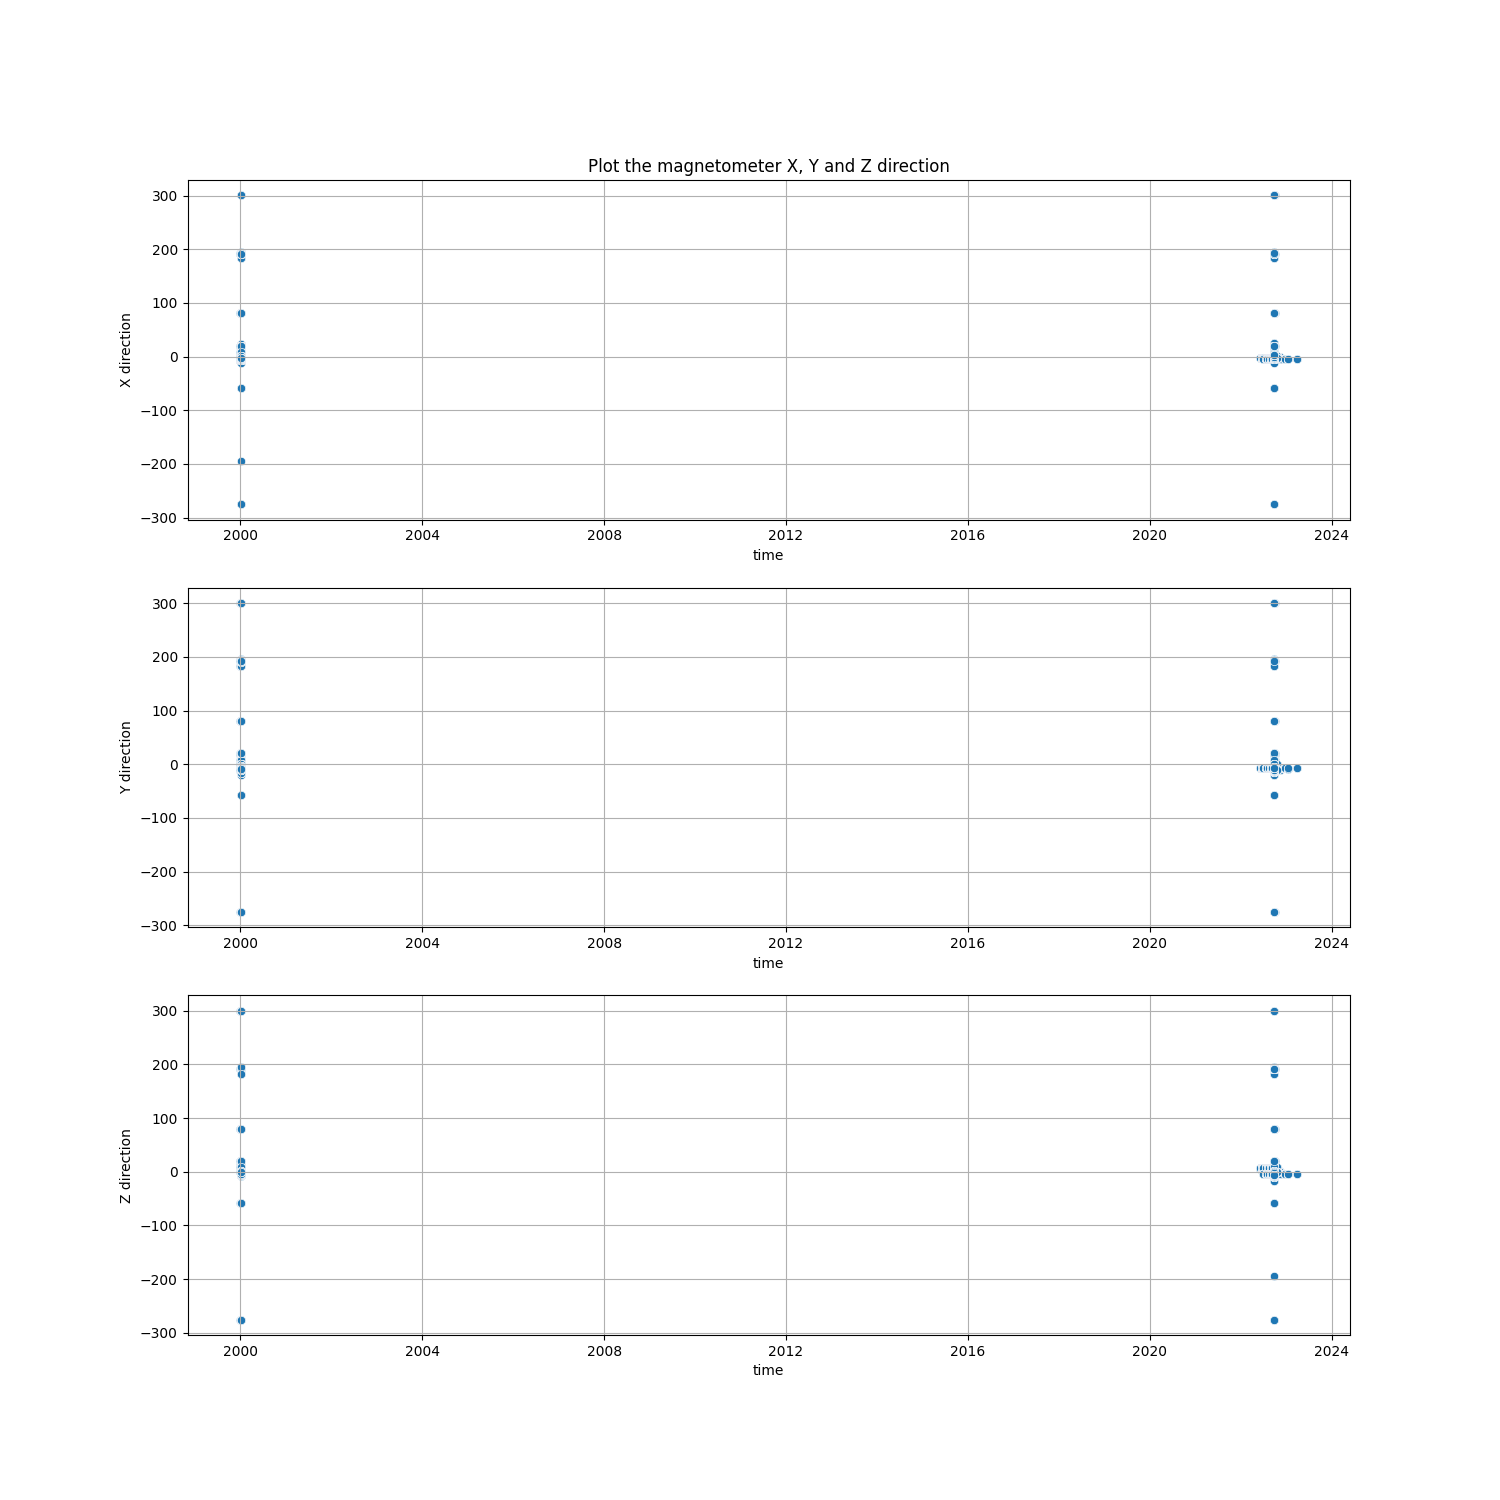

In [31]:
# Plot acceleration data against the whole time range
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.scatterplot(x='rtc_datetime', y='magnetometer_x', data=mag_df, ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('X direction')
axs[0].grid()

sns.scatterplot(x='rtc_datetime', y='magnetometer_y', data=mag_df, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('Y direction')
axs[1].grid()

sns.scatterplot(x='rtc_datetime', y='magnetometer_z', data=mag_df, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('Z direction')
axs[2].grid()

axs[0].set_title('Plot the magnetometer X, Y and Z direction')
#plt.savefig("/content/drive/MyDrive/Research_project/ground_surveys/all_range_acceleration_104.png")
plt.show()